In [1]:
import numpy as np
import pandas as pd

import os
import glob
import librosa
import tqdm
import pickle
import time

from collections import Counter, defaultdict

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import lr_scheduler
from torch import nn
import torch.nn.functional as F
import torch

from skmultilearn.model_selection import iterative_train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import utils
from flame import Trainer

sns.set()

DATA_PATH = './data'
join_path = lambda path: os.path.join(DATA_PATH, path)

In [2]:
with open(join_path('train_raw.pkl'), 'rb+') as f:
    train_X = pickle.load(f)
    
with open(join_path('val_raw.pkl'), 'rb+') as f:
    val_X = pickle.load(f)
    
train_y = np.load(join_path('train_targets.npy'))
val_y = np.load(join_path('val_targets.npy'))

In [3]:
train_ds = TensorDataset(torch.FloatTensor(train_X).unsqueeze(1).contiguous(), torch.FloatTensor(train_y))
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = TensorDataset(torch.FloatTensor(val_X).unsqueeze(1).contiguous(), torch.FloatTensor(val_y))
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

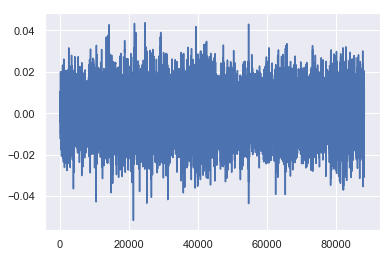

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_X[9])

In [5]:
# Sample-level Deep Convolutional Neural Networks for Music Auto-tagging Using Raw Waveforms
# https://arxiv.org/abs/1703.01789

ConvBlock = lambda in_channels, out_channels: nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3),
)

class SampleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convs = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, stride=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            ConvBlock(64, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 512),
            ConvBlock(512, 512),
        )
        
        self.head = nn.Linear(512, 80)
        
    def forward(self, x):
        return self.head(self.convs(x).view(x.shape[0], -1))

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()

model = SampleCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
logdir = join_path('SampleCNN_logdir')

trainer = Trainer(model, optimizer, criterion, device, logdir)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor=0.5,
    patience=10,
    verbose=True
)

In [7]:
print("Numebr of parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Numebr of parameters:  1854480


In [8]:
losses, best_loss, epoch_time = utils.train_model(trainer, train_dl, val_dl, val_y, scheduler,
                                            n_epochs=200, gap=20, verbose=True)

Epoch, best_val_lwlrap
   1, 0.0826
   2, 0.1302
   3, 0.1897
   4, 0.2231
   5, 0.2636
   6, 0.3058
   7, 0.3300
   8, 0.3645
   9, 0.3748
  10, 0.3918
  11, 0.4111
  12, 0.4347
  13, 0.4422
  14, 0.4641
  15, 0.4952
  16, 0.4957
  17, 0.5078
  18, 0.5307
  20, 0.5595
  21, 0.5631
  22, 0.5785
  26, 0.5997
  28, 0.6014
  29, 0.6023
  30, 0.6072
  31, 0.6127
  32, 0.6191
  33, 0.6246
  35, 0.6265
  43, 0.6266
  44, 0.6285
  49, 0.6352
Epoch    60: reducing learning rate of group 0 to 5.0000e-05.
  64, 0.6356
Epoch    75: reducing learning rate of group 0 to 2.5000e-05.
Done.


In [9]:
epoch_time, best_loss

(14.089719454447428, 0.6355785918034172)

In [11]:
min(losses['val']['logloss'])

0.0006636706118291546

Text(0.5,1,'Logloss')

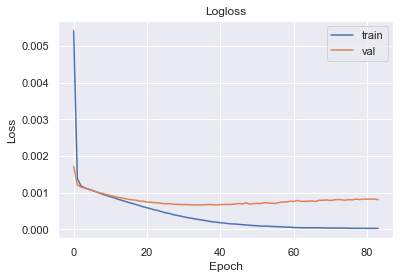

In [12]:
plt.plot(losses['train']['logloss'])
plt.plot(losses['val']['logloss'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Logloss')

Text(0.5,1,'Lwlrap')

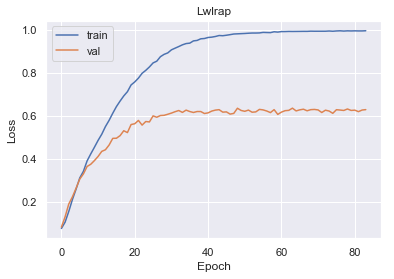

In [13]:
plt.plot(losses['train']['lwlrap'])
plt.plot(losses['val']['lwlrap'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Lwlrap')